In [2]:
import pandas as pd
import numpy as np
import os
import re

## Loading data

In [3]:
# load data into pandas
def read_data(dir_path):
    examples = []
    for filename in os.listdir(dir_path):
        if not filename.endswith("txt"):
            continue
        keys = filename.split(".")[0].split("_")
        assert len(keys) == 3
        # keys is [id, label, review_score]. For now we are only interested in the label
        label = keys[1]
        with open(os.path.join(dir_path, filename)) as f:
            text = f.read().strip().replace("<br />", " ")
        examples.append([text, 1 if label == 'pos' else 0])
    return examples

In [4]:
DEV_SIZE = 800

In [5]:
SDEV_DIR = '../imdb-data/sd{}'.format(DEV_SIZE)
sdev_data = read_data(SDEV_DIR)
sdev_df = pd.DataFrame(sdev_data, columns=['text', 'label'])
sdev_df

,text,label
0,It's beyond my comprehension that so much rubb...,1
1,'What I Like About You' is definitely a show t...,1
2,"ELVIRA, MISTRESS OF THE DARK (1988) directed ...",1
3,This is one of the most spiritual movies I hav...,1
4,"Man With the Gun is pretty much forgotten now,...",1
...,...,...
795,Police Story is one of Jackie Chan's classic f...,1
796,If you need cheering up on a cold weekday even...,1
797,A wonderful early musical film from Rene Clair...,1
798,"A light-hearted comedy, Nothing shows us a wor...",1


In [6]:
from sklearn.model_selection import train_test_split

TRAIN_DIR = '../imdb-data/og'
train_data = read_data(TRAIN_DIR)

all_train_df = pd.DataFrame(train_data, columns=['text', 'label'])
train_df = pd.concat([all_train_df, sdev_df]).drop_duplicates(keep=False)
train_df

,text,label
0,I have to start saying it has been a long time...,1
1,I thought that Mukhsin has been wonderfully wr...,1
2,First of all this was not a three hour movie -...,1
3,I cant understand at all why so many Godzilla ...,0
5,"""Hatred of a Minute"" is arguably one of the be...",1
...,...,...
24994,I agree with other users comments in that the ...,0
24995,This movie is about this wimpy guy who decides...,1
24997,I really enjoyed The 60's. Not being of that g...,1
24998,"While on a vacation at the beach, red-haired b...",0


## Labeling functions

In [7]:
# define constants to represent class labels
ABSTAIN = -1
POS = 1
NEG = 0

In [8]:
DISTANCE = 8

### Textblob

In [10]:
from snorkel.preprocess import preprocessor
from textblob import TextBlob
from snorkel.labeling import labeling_function


@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

pos_polarity_threshold = 0.15
neg_polarity_threshold = 0.08
@labeling_function(pre=[textblob_sentiment])
def pos_textblob_polarity(x):
    return POS if x.polarity > pos_polarity_threshold else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def neg_textblob_polarity(x):
    return NEG if x.polarity < neg_polarity_threshold else ABSTAIN

In [11]:
def textblob_polarity(x):
    scores = TextBlob(x)
    if scores.sentiment.polarity > pos_polarity_threshold:
        return POS
    elif scores.sentiment.polarity < neg_polarity_threshold:
        return NEG
    return ABSTAIN

In [12]:
textblob_pol = [textblob_polarity(x) for x in list(train_df['text'])]

In [13]:
df_textblob = train_df.copy()
df_textblob['textblob_label'] = textblob_pol

In [14]:
df_textblob = df_textblob[df_textblob['textblob_label'] != -1]

In [15]:
texts_textblob = list(df_textblob['text'])
labels_textblob = list(df_textblob['textblob_label'])

In [16]:
ds_textblob = [[text, label] for text, label in zip(texts_textblob, labels_textblob)]

## Get most indicative words using Naive Bayes on textblob generated dataset

In [16]:
from naive_bayes.imdb import return_keywords_indices

all_words, most_pos_indices, most_neg_indices = return_keywords_indices(ds_textblob)

Size of dictionary:  2951
Text matrix has been prepared.
Naive bayes model fit complete.


In [17]:
NUM_KEYWORDS = 50

top_pos_words = [all_words[ind] for ind in most_pos_indices[:NUM_KEYWORDS]]
top_neg_words = [all_words[ind] for ind in most_neg_indices[:NUM_KEYWORDS]]

In [18]:
print('Top pos words:')
print(top_pos_words)
print('\nTop neg words:')
print(top_neg_words)

# Remember to post-process these by removing those words that are correlational but not causal, e.g. 'germany'

Top pos words:
['delightful', 'superb', 'beautifully', 'wonderful', 'magnificent', 'breathtaking', 'delight', 'marvelous', 'wonderfully', 'awesome', 'excellent', 'exceptional', 'fantastic', 'brilliantly', 'favorites', 'fabulous', 'touching', 'greatest', 'unforgettable', 'amazing', 'brilliant', 'outstanding', 'perfect', 'nominated', 'winning', '910', 'loved', 'charming', 'warm', 'rose', '810', '1010', 'beautiful', 'perfectly', 'appreciated', 'incredible', 'oscars', 'gripping', 'lovely', 'ensemble', 'nicely', 'happiness', 'great', 'favorite', 'extraordinary', '710', 'oscar', 'stunning', 'underrated', 'refreshing']

Top neg words:
['atrocious', 'horribly', 'stupidity', 'worst', 'amateurish', 'awful', 'pathetic', 'horrible', 'incoherent', 'retarded', 'terrible', 'lousy', 'laughable', 'poorly', 'pointless', 'stupid', 'crap', 'lame', 'idiotic', 'dreadful', 'insulting', 'badly', 'waste', '110', 'worse', 'ridiculous', 'appalling', 'pile', 'disgusting', 'idiot', 'dumb', 'sucks', 'unfunny', 'ugl

In [17]:
pos_words = set(['delightful', 'superb', 'beautifully', 'wonderful', 'magnificent', 'breathtaking', 'delight', 'marvelous', 'wonderfully', 'awesome', 'excellent', 'exceptional', 'fantastic', 'brilliantly', 'favorites', 'fabulous', 'touching', 'greatest', 'unforgettable', 'amazing', 'brilliant', 'outstanding', 'perfect', 'nominated', 'winning', '910', 'loved', 'charming', 'warm', 'rose', '810', '1010', 'beautiful', 'perfectly', 'appreciated', 'incredible', 'oscars', 'gripping', 'lovely', 'ensemble', 'nicely', 'happiness', 'great', 'favorite', 'extraordinary', '710', 'oscar', 'stunning', 'underrated', 'refreshing'])
neg_words = set(['atrocious', 'horribly', 'stupidity', 'worst', 'amateurish', 'awful', 'pathetic', 'horrible', 'incoherent', 'retarded', 'terrible', 'lousy', 'laughable', 'poorly', 'pointless', 'stupid', 'crap', 'lame', 'idiotic', 'dreadful', 'insulting', 'badly', 'waste', '110', 'worse', 'ridiculous', 'appalling', 'pile', 'disgusting', 'idiot', 'dumb', 'sucks', 'unfunny', 'ugly', 'remotely', 'bad', 'nasty', 'wasting', 'ripoff', 'boring', 'random', 'alien', 'whatsoever', 'inept', 'annoying', 'excuse', 'utter', 'tedious', 'horrendous', 'zero'])

## Applying and tuning LFs

In [18]:
from snorkel.labeling import labeling_function

neg_adjs = set([
    'bad', 'worst', 'horrible', 'terrible', 'stupid', 'boring', 'dreadful', 'disgust',
    'disturbing', 'problem', 'disaster', 'a waste', 'not a fan'
])

@labeling_function()
def neg_adj(x):
    text = x.text.lower()
    for word in neg_adjs:
        char_index = text.find(word)
        if char_index != -1:
            substring = text[max(char_index - DISTANCE, 0):char_index]
            if ('not' in substring) or ('n\'t' in substring) :
                continue
            else:
                return NEG
    return ABSTAIN


@labeling_function()
def detect_pos_words_from_naive_bayes(x):
    return POS if any(re.search(r'[\.!?\-\s]' + word + r'[\.!?\-\s]', x.text.lower()) \
                      for word in pos_words) else ABSTAIN
    #return POS if any(word in x.text.lower() for word in pos_words) else ABSTAIN

@labeling_function()
def detect_neg_words_from_naive_bayes(x):
    return NEG if any(re.search(r'[\.!?\-\s]' + word + r'[\.!?\-\s]', x.text.lower()) \
                      for word in neg_words) else ABSTAIN
    #return NEG if any(word in x.text.lower() for word in neg_words) else ABSTAIN
    
@labeling_function()    
def detect_pos_exclamation(x):
    return POS if all(not re.search(r'[\.!?\-\s]' + word + r'[\.!?\-\s]', x.text.lower()) for word in neg_words) \
                    and '!' in x.text.lower() else ABSTAIN
@labeling_function()                      
def detect_neg_exclamation(x):
    return NEG if all(not re.search(r'[\.!?\-\s]' + word + r'[\.!?\-\s]', x.text.lower()) for word in pos_words) \
                    and '!' in x.text.lower() else ABSTAIN

@labeling_function()
def score_keywords(x):
    text = x.text.lower()
    pos_word_score = 1.0
    neg_word_score = -1.0
    score = 0
    for word in pos_words:
        if re.search(r'[\.!?\-\s]' + word + r'[\.!?\-\s]', text):
            score += pos_word_score
    for word in neg_words:
        if re.search(r'[\.!?\-\s]' + word + r'[\.!?\-\s]', text):
            score += neg_word_score
    if score > 0:
        return POS
    elif score < 0:
        return NEG
    return ABSTAIN

zero_score = r'0(( out of )|/)10'
neg_score = r'[1-4](( out of )|/)10'
pos_score = r'[6789](( out of )|/)10'
full_score = r'10(( out of )|/)10'
@labeling_function()
def find_user_review_score(x):
    if re.search(neg_score, x.text.lower()) :
        return NEG
    elif re.search(pos_score, x.text.lower()) or re.search(full_score, x.text.lower()):
        return POS
    elif re.search(zero_score, x.text.lower()):
        # we know there's no full score
        return NEG
    return ABSTAIN

In [19]:
lfs = [neg_adj, 
       detect_pos_exclamation, score_keywords, find_user_review_score, pos_textblob_polarity, neg_textblob_polarity]
# detect_pos_words_from_naive_bayes, detect_neg_words_from_naive_bayes,

In [20]:
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis

applier = PandasLFApplier(lfs=lfs)

In [21]:
L_sdev = applier.apply(df=sdev_df)
LFAnalysis(L=L_sdev, lfs=lfs).lf_summary(Y=np.asarray(sdev_df["label"]))

100%|██████████| 800/800 [00:05<00:00, 158.97it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
neg_adj,0,[0],0.44625,0.42625,0.12875,251,106,0.703081
detect_pos_exclamation,1,[1],0.14750,0.13875,0.04000,95,23,0.805085
score_keywords,2,"[0, 1]",0.76000,0.72000,0.14625,535,73,0.879934
find_user_review_score,3,"[0, 1]",0.07375,0.07250,0.02625,54,5,0.915254
pos_textblob_polarity,4,[1],0.38750,0.33500,0.08500,262,48,0.845161
neg_textblob_polarity,5,[0],0.44000,0.39375,0.07875,281,71,0.798295


In [22]:
L_train = applier.apply(df=train_df)
LFAnalysis(L=L_train, lfs=lfs).lf_summary(Y=np.asarray(train_df["label"]))

100%|██████████| 24016/24016 [02:28<00:00, 161.29it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
neg_adj,0,[0],0.445286,0.426632,0.120586,7675,3019,0.717692
detect_pos_exclamation,1,[1],0.150316,0.141322,0.037433,2802,808,0.776177
score_keywords,2,"[0, 1]",0.745128,0.696078,0.139407,15283,2612,0.854037
find_user_review_score,3,"[0, 1]",0.083195,0.080655,0.027981,1916,82,0.958959
pos_textblob_polarity,4,[1],0.374667,0.325450,0.086193,7409,1589,0.823405
neg_textblob_polarity,5,[0],0.432170,0.386492,0.064665,8324,2055,0.802004


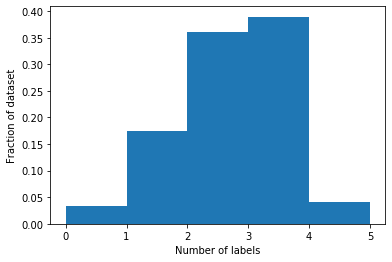

In [23]:
import matplotlib.pyplot as plt
def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

## Testing Majority Vote (baseline) on sdev set

In [24]:
from snorkel.labeling import MajorityLabelVoter

majority_model = MajorityLabelVoter()
majority_acc = majority_model.score(L=L_sdev, Y=np.asarray(sdev_df["label"]))["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

Majority Vote Accuracy:   84.6%


In [25]:
# Attention: this part is pseudo-cheating!

majority_model_test_acc = majority_model.score(L=L_train, Y=np.asarray(train_df["label"]))['accuracy']
print(f"{'Majority Vote Accuracy:':<25} {majority_model_test_acc * 100:.1f}%")

Majority Vote Accuracy:   83.1%


## Training Generative Model on train set and testing it on sdev set

In [26]:
from snorkel.labeling import LabelModel

label_model = LabelModel(cardinality=2)
label_model.fit(L_train=L_train, n_epochs=500, lr=.01, log_freq=1, Y_dev=np.asarray(sdev_df["label"]))

In [27]:
label_model.get_weights()

array([0.83884084, 0.92928007, 0.97017688, 0.85468504, 0.97968364,
       0.92186278])

In [28]:
label_model_perf = label_model.score(L=L_sdev, Y=np.asarray(sdev_df["label"]))
print(label_model_perf)

{'accuracy': 0.819693094629156}


In [29]:
# Attention: this part is pseudo-cheating!

label_model_test_perf = label_model.score(L=L_train, Y=np.asarray(train_df["label"]))
print(label_model_test_perf)

{'accuracy': 0.8039148055531603}


In [128]:
from sklearn.metrics import roc_auc_score
roc_auc_score(list(df['label']), list(df['snorkel_label']))

0.8803081672254527

## Filtering out unlabeled data points

In [101]:
model = label_model

### Filter

In [102]:
#preds_train = model.predict(L=L_train, return_probs=False)

In [103]:
probs_train = model.predict_proba(L_train)[:, 1]

In [104]:
probs_train

array([9.97783850e-01, 2.00110022e-04, 9.02104021e-01, ...,
       9.94625923e-01, 4.64275044e-01, 3.07120292e-01])

In [123]:
df = train_df.copy()
df['snorkel_label'] = probs_train
df

,text,label,snorkel_label
0,I have to start saying it has been a long time...,1,0.997784
1,I thought that Mukhsin has been wonderfully wr...,1,0.000200
2,First of all this was not a three hour movie -...,1,0.902104
3,I cant understand at all why so many Godzilla ...,0,0.000028
5,"""Hatred of a Minute"" is arguably one of the be...",1,0.995177
...,...,...,...
24994,I agree with other users comments in that the ...,0,0.000200
24995,This movie is about this wimpy guy who decides...,1,0.085249
24997,I really enjoyed The 60's. Not being of that g...,1,0.994626
24998,"While on a vacation at the beach, red-haired b...",0,0.464275


In [124]:
#df = df[df['snorkel_label'] != 0.5]
df = pd.concat([df[df['snorkel_label'] > 0.6], df[df['snorkel_label'] < 0.4]])

In [125]:
df

,text,label,snorkel_label
0,I have to start saying it has been a long time...,1,0.997784
2,First of all this was not a three hour movie -...,1,0.902104
5,"""Hatred of a Minute"" is arguably one of the be...",1,0.995177
6,"I'm tired of people judging films on their ""hi...",1,0.999889
9,Cannot believe my eyes when read quite a bunch...,1,0.659586
...,...,...,...
24990,this film really tries to hard. if your going ...,0,0.041364
24992,The 1930s saw a vogue for documentary films ab...,0,0.021586
24994,I agree with other users comments in that the ...,0,0.000200
24995,This movie is about this wimpy guy who decides...,1,0.085249


## Label Quality Analysis

In [84]:
from sklearn.metrics import classification_report

In [85]:
print(classification_report(list(df['label']), list(df['snorkel_label'])))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

## Export dataframe

In [129]:
df = df.drop(columns=['label'])
df

,text,snorkel_label
0,I have to start saying it has been a long time...,0.997784
2,First of all this was not a three hour movie -...,0.902104
5,"""Hatred of a Minute"" is arguably one of the be...",0.995177
6,"I'm tired of people judging films on their ""hi...",0.999889
9,Cannot believe my eyes when read quite a bunch...,0.659586
...,...,...
24990,this film really tries to hard. if your going ...,0.041364
24992,The 1930s saw a vogue for documentary films ab...,0.021586
24994,I agree with other users comments in that the ...,0.000200
24995,This movie is about this wimpy guy who decides...,0.085249


### Merging labels

In [39]:
df = df.rename(columns={"snorkel_label": "label"})
df

,text,label
0,I have to start saying it has been a long time...,1
1,I thought that Mukhsin has been wonderfully wr...,0
3,I cant understand at all why so many Godzilla ...,0
5,"""Hatred of a Minute"" is arguably one of the be...",1
6,"I'm tired of people judging films on their ""hi...",1
...,...,...
24992,The 1930s saw a vogue for documentary films ab...,0
24993,I managed to catch a late night double feature...,1
24994,I agree with other users comments in that the ...,0
24995,This movie is about this wimpy guy who decides...,0


In [40]:
df = pd.concat([sdev_df, df])
df

,text,label
0,It's beyond my comprehension that so much rubb...,1
1,'What I Like About You' is definitely a show t...,1
2,"ELVIRA, MISTRESS OF THE DARK (1988) directed ...",1
3,This is one of the most spiritual movies I hav...,1
4,"Man With the Gun is pretty much forgotten now,...",1
...,...,...
24992,The 1930s saw a vogue for documentary films ab...,0
24993,I managed to catch a late night double feature...,1
24994,I agree with other users comments in that the ...,0
24995,This movie is about this wimpy guy who decides...,0


In [130]:
export_path = '../imdb-data/wd04.csv'
df.to_csv(export_path, header=False, index=False)